$$
\newcommand{\argmax}{arg\,max}
\newcommand{\argmin}{arg\,min}
$$

# The Aiyagari Model

# GPU

This lecture was built using a machine with access to a GPU.

[Google Colab](https://colab.research.google.com/) has a free tier with GPUs
that you can access as follows:

1. Click on the “play” icon top right  
1. Select Colab  
1. Set the runtime environment to include a GPU  

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bew77](https://python.quantecon.org/zreferences.html#id173)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiy94](https://python.quantecon.org/zreferences.html#id137)].

The model features

- Heterogeneous agents  
- A single exogenous vehicle for borrowing and lending  
- Limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94](https://python.quantecon.org/zreferences.html#id138)]  
- risk sharing and asset pricing [[HL96](https://python.quantecon.org/zreferences.html#id130)]  
- the shape of the wealth distribution [[BBZ15](https://python.quantecon.org/zreferences.html#id131)]  

### References

The primary reference for this lecture is [[Aiy94](https://python.quantecon.org/zreferences.html#id138)].

A textbook treatment is available in chapter 18 of [[LS18](https://python.quantecon.org/zreferences.html#id183)].

A less sophisticated version of this lecture (without JAX) can be found
[here](https://python.quantecon.org/aiyagari.html).

### Preliminaries

We use the following imports

In [78]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from collections import namedtuple

Let’s check the GPU we are running

In [79]:
%config InlineBackend.figure_format = 'svg'

We will use 64 bit floats with JAX in order to increase the precision.

In [80]:
jax.config.update("jax_enable_x64", True)

We will use the following function to compute stationary distributions of stochastic matrices.  (For a reference to the algorithm, see p. 88 of [Economic Dynamics](https://johnstachurski.net/edtc).)

In [81]:
@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

## Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y = A K^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
\max_{K, N} \left\{ A K^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

These parameters are stored in the following namedtuple.

In [82]:
Firm = namedtuple("Firm", ("A", "N", "α", "δ"))


def create_firm(A=1.0, N=1.0, α=0.33, δ=0.05):
    """
    Create a namedtuple that stores firm data.

    """
    return Firm(A=A, N=N, α=α, δ=δ)

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{18.1}
$$

In [83]:
def r_given_k(K, firm):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    A, N, α, δ = firm
    return A * α * (N / K) ** (1 - α) - δ

Using [(18.1)](#equation-equation-aiy-rgk) and the firm’s first-order condition for labor,


<a id='equation-equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{18.2}
$$

In [84]:
def r_to_w(r, firm):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    A, N, α, δ = firm
    return A * (1 - α) * (A * α / (r + δ)) ** (α / (1 - α))

## Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

In this simple version of the model, households supply labor  inelastically because they do not value leisure.

Below we provide code to solve the household problem, taking $ r $ and $ w $ as fixed.

### Primitives and Operators

We will solve the household problem using Howard policy iteration
(see Ch 5 of [Dynamic Programming](https://dp.quantecon.org/)).

First we set up a namedtuple to store the parameters that define a household asset
accumulation problem, as well as the grids used to solve it.

In [85]:
Household = namedtuple("Household", ("β", "a_grid", "z_grid", "Π"))

In [86]:
def create_household(
    β=0.96,  # Discount factor
    Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
    z_grid=[0.1, 1.0],  # Exogenous states
    a_min=1e-10,
    a_max=20,  # Asset grid
    a_size=200,
):
    """
    Create a namedtuple that stores all data needed to solve the household
    problem, given prices.

    """
    a_grid = jnp.linspace(a_min, a_max, a_size)
    z_grid, Π = map(jnp.array, (z_grid, Π))
    return Household(β=β, a_grid=a_grid, z_grid=z_grid, Π=Π)

For now we assume that $ u(c) = \log(c) $.

(CRRA utility is treated in the exercises.)

In [87]:
u = jnp.log

Here’s a tuple that stores the wage rate and interest rate, as well as a function that creates a price namedtuple with default values.

In [88]:
Prices = namedtuple("Prices", ("r", "w"))


def create_prices(
    r=0.01,  # Interest rate
    w=1.0,
):  # Wages
    return Prices(r=r, w=w)

Now we set up a vectorized version of the right-hand side of the Bellman equation
(before maximization), which is a 3D array representing

$$
B(a, z, a') = u(wz + (1+r)a - a') + \beta \sum_{z'} v(a', z') Π(z, z')
$$

for all $ (a, z, a') $.

In [89]:
@jax.jit
def B(v, household, prices):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a = jnp.reshape(a_grid, (a_size, 1, 1))  # a[i]   ->  a[i, j, ip]
    z = jnp.reshape(z_grid, (1, z_size, 1))  # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))  # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)  # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * EV, -jnp.inf)

The next function computes greedy policies.

In [90]:
@jax.jit
def get_greedy(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices.  If
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.

    """
    return jnp.argmax(B(v, household, prices), axis=-1)  # argmax over ap

The following function computes the array $ r_{\sigma} $ which gives current
rewards given policy $ \sigma $.

In [91]:
@jax.jit
def compute_r_σ(σ, household, prices):
    """
    Compute current rewards at each i, j under policy σ.  In particular,

        r_σ[i, j] = u((1 + r)a[i] + wz[j] - a'[ip])

    when ip = σ[i, j].

    """
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r) * a + w * z - ap
    r_σ = u(c)

    return r_σ

The value $ v_{\sigma} $ of a policy $ \sigma $ is defined as

$$
v_{\sigma} = (I - \beta P_{\sigma})^{-1} r_{\sigma}
$$

(See Ch 5 of [Dynamic Programming](https://dp.quantecon.org/) for notation and background on Howard policy iteration.)

To compute this vector, we set up the linear map $ v \rightarrow R_{\sigma} v $, where $ R_{\sigma} := I - \beta P_{\sigma} $.

This map can be expressed as

$$
(R_{\sigma} v)(a, z) = v(a, z) - \beta \sum_{z'} v(\sigma(a, z), z') Π(z, z')
$$

(Notice that $ R_\sigma $ is expressed as a linear operator rather than a matrix – this is much easier and cleaner to code, and also exploits sparsity.)

In [92]:
@jax.jit
def R_σ(v, σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=-1)

The next function computes the lifetime value of a given policy.

In [93]:
@jax.jit
def get_value(σ, household, prices):
    """
    Get the lifetime value of policy σ by computing

        v_σ = R_σ^{-1} r_σ

    """
    r_σ = compute_r_σ(σ, household, prices)
    # Reduce R_σ to a function in v
    _R_σ = lambda v: R_σ(v, σ, household)
    # Compute v_σ = R_σ^{-1} r_σ using an iterative routing.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ, r_σ)[0]

Here’s the Howard policy iteration.

In [94]:
def howard_policy_iteration(
    household, prices, tol=1e-4, max_iter=10_000, verbose=False
):
    """
    Howard policy iteration routine.

    """
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    σ = jnp.zeros((a_size, z_size), dtype=int)

    v_σ = get_value(σ, household, prices)
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        σ_new = get_greedy(v_σ, household, prices)
        v_σ_new = get_value(σ_new, household, prices)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        σ = σ_new
        v_σ = v_σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    return σ

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices.

In [95]:
# Create an instance of Household
household = create_household()
prices = create_prices()

In [96]:
r, w = prices

In [97]:
r, w

(0.01, 1.0)

In [98]:
%time σ_star = howard_policy_iteration(household, prices, verbose=True)

Concluded loop 1 with error 11.367581056499507.
Concluded loop 2 with error 9.573888412438013.
Concluded loop 3 with error 3.965366352017865.
Concluded loop 4 with error 1.1207159237595592.
Concluded loop 5 with error 0.25239174802693043.
Concluded loop 6 with error 0.12172287140851346.
Concluded loop 7 with error 0.04339722928566658.
Concluded loop 8 with error 0.012130644685949932.
Concluded loop 9 with error 0.005821483366545976.
Concluded loop 10 with error 0.002862995691272019.
Concluded loop 11 with error 0.0016667442952904565.
Concluded loop 12 with error 0.000416446398701531.
Concluded loop 13 with error 0.0.
CPU times: user 211 ms, sys: 18.6 ms, total: 229 ms
Wall time: 92 ms


The next plot shows asset accumulation policies at different values of the exogenous state.

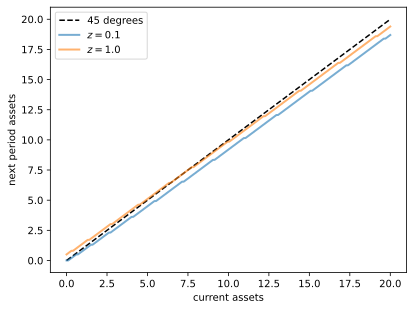

In [99]:
β, a_grid, z_grid, Π = household

fig, ax = plt.subplots()
ax.plot(a_grid, a_grid, "k--", label="45 degrees")
for j, z in enumerate(z_grid):
    lb = f"$z = {z:.2}$"
    policy_vals = a_grid[σ_star[:, j]]
    ax.plot(a_grid, policy_vals, lw=2, alpha=0.6, label=lb)
    ax.set_xlabel("current assets")
    ax.set_ylabel("next period assets")
ax.legend(loc="upper left")
plt.show()

### Capital Supply

To start thinking about equilibrium, we need to know how much capital households supply at a given interest rate $ r $.

This quantity can be calculated by taking the stationary distribution of assets under the optimal policy and computing the mean.

The next function computes the stationary distribution for a given policy $ \sigma $ via the following steps:

- compute the stationary distribution $ \psi = (\psi(a, z)) $ of $ P_{\sigma} $, which defines the
  Markov chain of the state $ (a_t, z_t) $ under policy $ \sigma $.  
- sum out $ z_t $ to get the marginal distribution for $ a_t $.  

In [100]:
@jax.jit
def compute_asset_stationary(σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Let’s give this a test run.

In [101]:
ψ_a = compute_asset_stationary(σ_star, household)

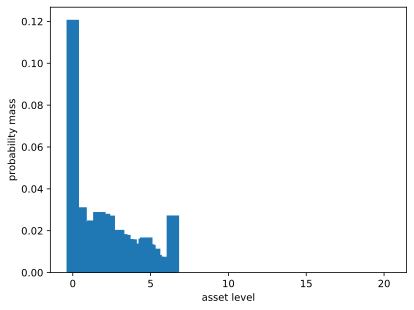

In [102]:
fig, ax = plt.subplots()
ax.bar(household.a_grid, ψ_a)
ax.set_xlabel("asset level")
ax.set_ylabel("probability mass")
plt.show()

The distribution should sum to one:

In [103]:
ψ_a.sum()

Array(1., dtype=float64)

The next function computes aggregate capital supply by households under policy $ \sigma $, given wages and interest rates.

In [104]:
def capital_supply(σ, household):
    """
    Induced level of capital stock under the policy, taking r and w as given.

    """
    β, a_grid, z_grid, Π = household
    ψ_a = compute_asset_stationary(σ, household)
    return float(jnp.sum(ψ_a * a_grid))

## Equilibrium

We compute a **stationary rational expectations equilibrium** (SREE) as follows:

1. set $ n=0 $, start with initial guess $ K_0 $ for aggregate capital  
1. determine prices $ r, w $ from the firm decision problem, given $ K_n $  
1. compute the optimal savings policy of the households given these prices  
1. compute aggregate capital $ K_{n+1} $ as the mean of steady state capital given this savings policy  
1. if $ K_{n+1} \approx K_n $ stop, otherwise go to step 2.  


We can write the sequence of operations in steps 2-4 as

$$
K_{n + 1} = G(K_n)
$$

If $ K_{n+1} $ agrees with $ K_n $ then we have a SREE.

In other words, our problem is to find the fixed-point of the one-dimensional map $ G $.

Here’s $ G $ expressed as a Python function:

In [105]:
def G(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)
    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = create_prices(r=r, w=w)
    σ_star = howard_policy_iteration(household, prices)
    return capital_supply(σ_star, household)

### Visual inspection

Let’s inspect visually as a first pass.

In [106]:
num_points = 50
firm = create_firm()
household = create_household()
k_vals = np.linspace(4, 12, num_points)
out = [G(k, firm, household) for k in k_vals]

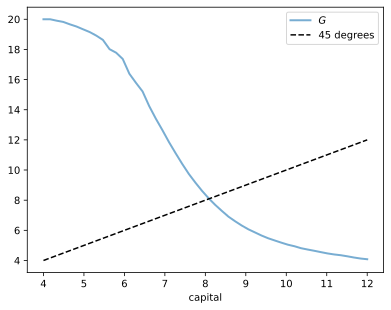

In [107]:
fig, ax = plt.subplots()
ax.plot(k_vals, out, lw=2, alpha=0.6, label="$G$")
ax.plot(k_vals, k_vals, "k--", label="45 degrees")
ax.set_xlabel("capital")
ax.legend()
plt.show()

### Computing the equilibrium

Now let’s compute the equilibrium.

Looking at the figure above, we see that a simple iteration scheme $ K_{n+1} = G(K_n) $ will cycle from high to low values, leading to slow convergence.

As a result, we use a damped iteration scheme of the form

$$
K_{n+1} = \alpha K_n + (1-\alpha) G(K_n)
$$

In [108]:
def compute_equilibrium(
    firm,
    household,
    K0=6,
    α=0.99,
    max_iter=1_000,
    tol=1e-4,
    print_skip=50,
    verbose=False,
):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = α * K + (1 - α) * G(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

In [109]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium capital stock")
start = time.time()
K_star, n = compute_equilibrium(firm, household, K0=6.0, verbose=True)
elapsed = time.time() - start
print(f"Computed equilibrium {K_star:.5} in {n} iterations and {elapsed} seconds")


Computing equilibrium capital stock
At iteration 50 with error 0.008397515264434219
At iteration 100 with error 0.0009559876839482229
At iteration 150 with error 0.00017041810880513708
Computed equilibrium 8.0918 in 176 iterations and 3.1939280033111572 seconds


This is not very fast, given how quickly we can solve the household problem.

You can try varying $ \alpha $, but usually this parameter is hard to set a priori.

In the exercises below you will be asked to use bisection instead, which generally performs better.

## Exercises

## Exercise 18.1

Write a new version of `compute_equilibrium` that uses `bisect` from `scipy.optimize` instead of damped iteration.

See if you can make it faster that the previous version.

In `bisect`,

- you should set `xtol=1e-4` to have the same error tolerance as the previous version.  
- for the lower and upper bounds of the bisection routine try `a = 1.0` and `b = 20.0`.  

## Solution

In [110]:
from scipy.optimize import bisect

We use bisection to find the zero of the function $ h(k) = k - G(k) $.

In [111]:
def compute_equilibrium(firm, household, a=1.0, b=20.0):
    K = bisect(lambda k: k - G(k, firm, household), a, b, xtol=1e-4)
    return K

In [ ]:
firm = create_firm()
household = create_household()
print("\nComputing equilibrium capital stock")
start = time.time()
K_star = compute_equilibrium(firm, household)
elapsed = time.time() - start
print(f"Computed equilibrium capital stock {K_star:.5} in {elapsed} seconds")


Computing equilibrium capital stock
Computed equilibrium capital stock 8.0938 in 0.07935690879821777 seconds


Bisection seems to be faster than the damped iteration scheme.

## Exercise 18.2

Show how equilibrium capital stock changes with $ \beta $.

Use the following values of $ \beta $ and plot the relationship you find.

In [113]:
β_vals = np.linspace(0.94, 0.98, 20)

## Solution

In [114]:
K_vals = np.empty_like(β_vals)
K = 6.0  # initial guess

for i, β in enumerate(β_vals):
    household = create_household(β=β)
    K = compute_equilibrium(firm, household, 0.5 * K, 1.5 * K)
    print(f"Computed equilibrium {K:.4} at β = {β}")
    K_vals[i] = K

Computed equilibrium 6.006 at β = 0.94
Computed equilibrium 6.186 at β = 0.9421052631578947
Computed equilibrium 6.379 at β = 0.9442105263157894
Computed equilibrium 6.577 at β = 0.9463157894736841
Computed equilibrium 6.786 at β = 0.9484210526315789
Computed equilibrium 7.005 at β = 0.9505263157894737
Computed equilibrium 7.226 at β = 0.9526315789473684
Computed equilibrium 7.461 at β = 0.9547368421052631
Computed equilibrium 7.709 at β = 0.9568421052631578
Computed equilibrium 7.966 at β = 0.9589473684210525
Computed equilibrium 8.231 at β = 0.9610526315789474
Computed equilibrium 8.499 at β = 0.9631578947368421
Computed equilibrium 8.787 at β = 0.9652631578947368
Computed equilibrium 9.076 at β = 0.9673684210526315
Computed equilibrium 9.378 at β = 0.9694736842105263
Computed equilibrium 9.687 at β = 0.971578947368421
Computed equilibrium 10.0 at β = 0.9736842105263157
Computed equilibrium 10.34 at β = 0.9757894736842105
Computed equilibrium 10.67 at β = 0.9778947368421053
Computed 

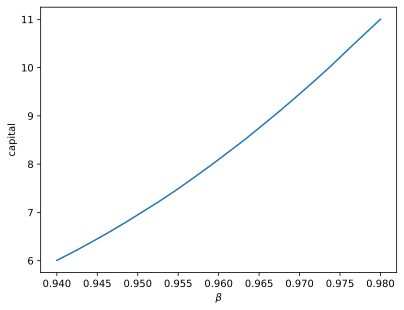

In [115]:
fig, ax = plt.subplots()
ax.plot(β_vals, K_vals, ms=2)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel("capital")
plt.show()